In [13]:
import sys
sys.path.append('../src/')
from tqdm import tqdm
import pandas as pd
import wandb
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt


In [14]:
api = wandb.Api()
entity, project = "ajzero", "AlphaZero"
tags = ['2024-04-26-15-30-10', '2024-04-25-19-54-41', '2024-04-25-21-23-45', '2024-04-26-09-48-53','2024-04-26-11-22-32', '2024-05-01-11-32-26']
filters = {"tags": {"$in": tags}, "state": "finished", "config.use_visit_count": True}
runs = api.runs(entity + "/" + project, filters=filters)
runs


<Runs ajzero/AlphaZero>

In [15]:
data = []
for run in tqdm(runs):
    summary = run.summary._json_dict
    config = run.config
    summary.update(config)
    data.append(summary)

df = pd.DataFrame(data)

# filter out runs with Evaluation/Mean_Returns == -100
df = df[df['Evaluation/Mean_Returns'] != -100]

ncols, nrows = df["ncols"][0], 6
df

100%|██████████| 120/120 [00:00<00:00, 135.25it/s]


,_step,Training/Value_Simularities,grad_steps,Training/Value_and_Policy_loss,Evaluation/Mean_Entropy,Self_Play/Min_Return,Self_Play/Mean_Discounted_Return,Self_Play/Returns,Self_Play/Mean_Entropy,Evaluation/Mean_Returns,...,policy_loss_weight,sample_batch_ratio,tree_value_transform,observation_embedding,regularization_weight,root_selection_policy,episodes_per_iteration,tree_evaluation_policy,replay_buffer_multiplier,selection_value_transform
0,29,0.438454,116,17.057392,2.590821e-07,-13,-13.000000,"{'_type': 'histogram', 'bins': [-13.5, -13.484...",2.385336e-08,-13,...,0.3,4,identity,coordinate,0.000001,PolicyPUCT,6,mvc,15,identity
1,29,0.395075,116,17.418075,3.122809e-01,-27,-21.833334,"{'values': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",3.385172e-01,-15,...,0.3,4,identity,coordinate,0.000001,PUCT,6,mvc,15,identity
2,29,0.761117,116,90.172625,3.245102e-01,-29,-22.333334,"{'_type': 'histogram', 'bins': [-29, -28.84375...",3.608111e-01,-17,...,0.3,4,identity,coordinate,0.000001,PUCT,6,visit,15,identity
3,29,0.330454,116,13.358126,9.558185e-06,-13,-13.000000,"{'_type': 'histogram', 'bins': [-13.5, -13.484...",1.227000e-06,-13,...,0.3,4,identity,coordinate,0.000001,PolicyPUCT,6,mvc,15,identity
4,29,0.681036,116,20.381270,2.635206e-01,-23,-20.000000,"{'bins': [-23, -22.90625, -22.8125, -22.71875,...",3.835076e-01,-15,...,0.3,4,identity,coordinate,0.000001,PUCT,6,mvc,15,identity
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,29,0.636869,116,35.879909,2.437734e-01,-19,-16.166666,"{'_type': 'histogram', 'bins': [-19, -18.9375,...",2.419702e-01,-15,...,0.3,4,identity,coordinate,0.000001,PUCT,6,mvc,15,identity
116,29,0.752751,116,217.295216,4.993233e-01,-256,-81.666664,"{'_type': 'histogram', 'values': [1, 0, 0, 0, ...",5.322037e-01,-17,...,0.3,4,identity,coordinate,0.000001,PUCT,6,visit,15,identity
117,29,0.737890,116,296.337814,5.761422e-01,-397,-132.666672,"{'_type': 'histogram', 'values': [1, 0, 0, 0, ...",6.903391e-01,-15,...,0.3,4,identity,coordinate,0.000001,PUCT,6,visit,15,identity
118,29,0.089983,116,5.546653,3.292095e-02,-13,-13.000000,"{'bins': [-13.5, -13.484375, -13.46875, -13.45...",1.843795e-02,-13,...,0.3,4,identity,coordinate,0.000001,PolicyPUCT,6,mvc,15,identity


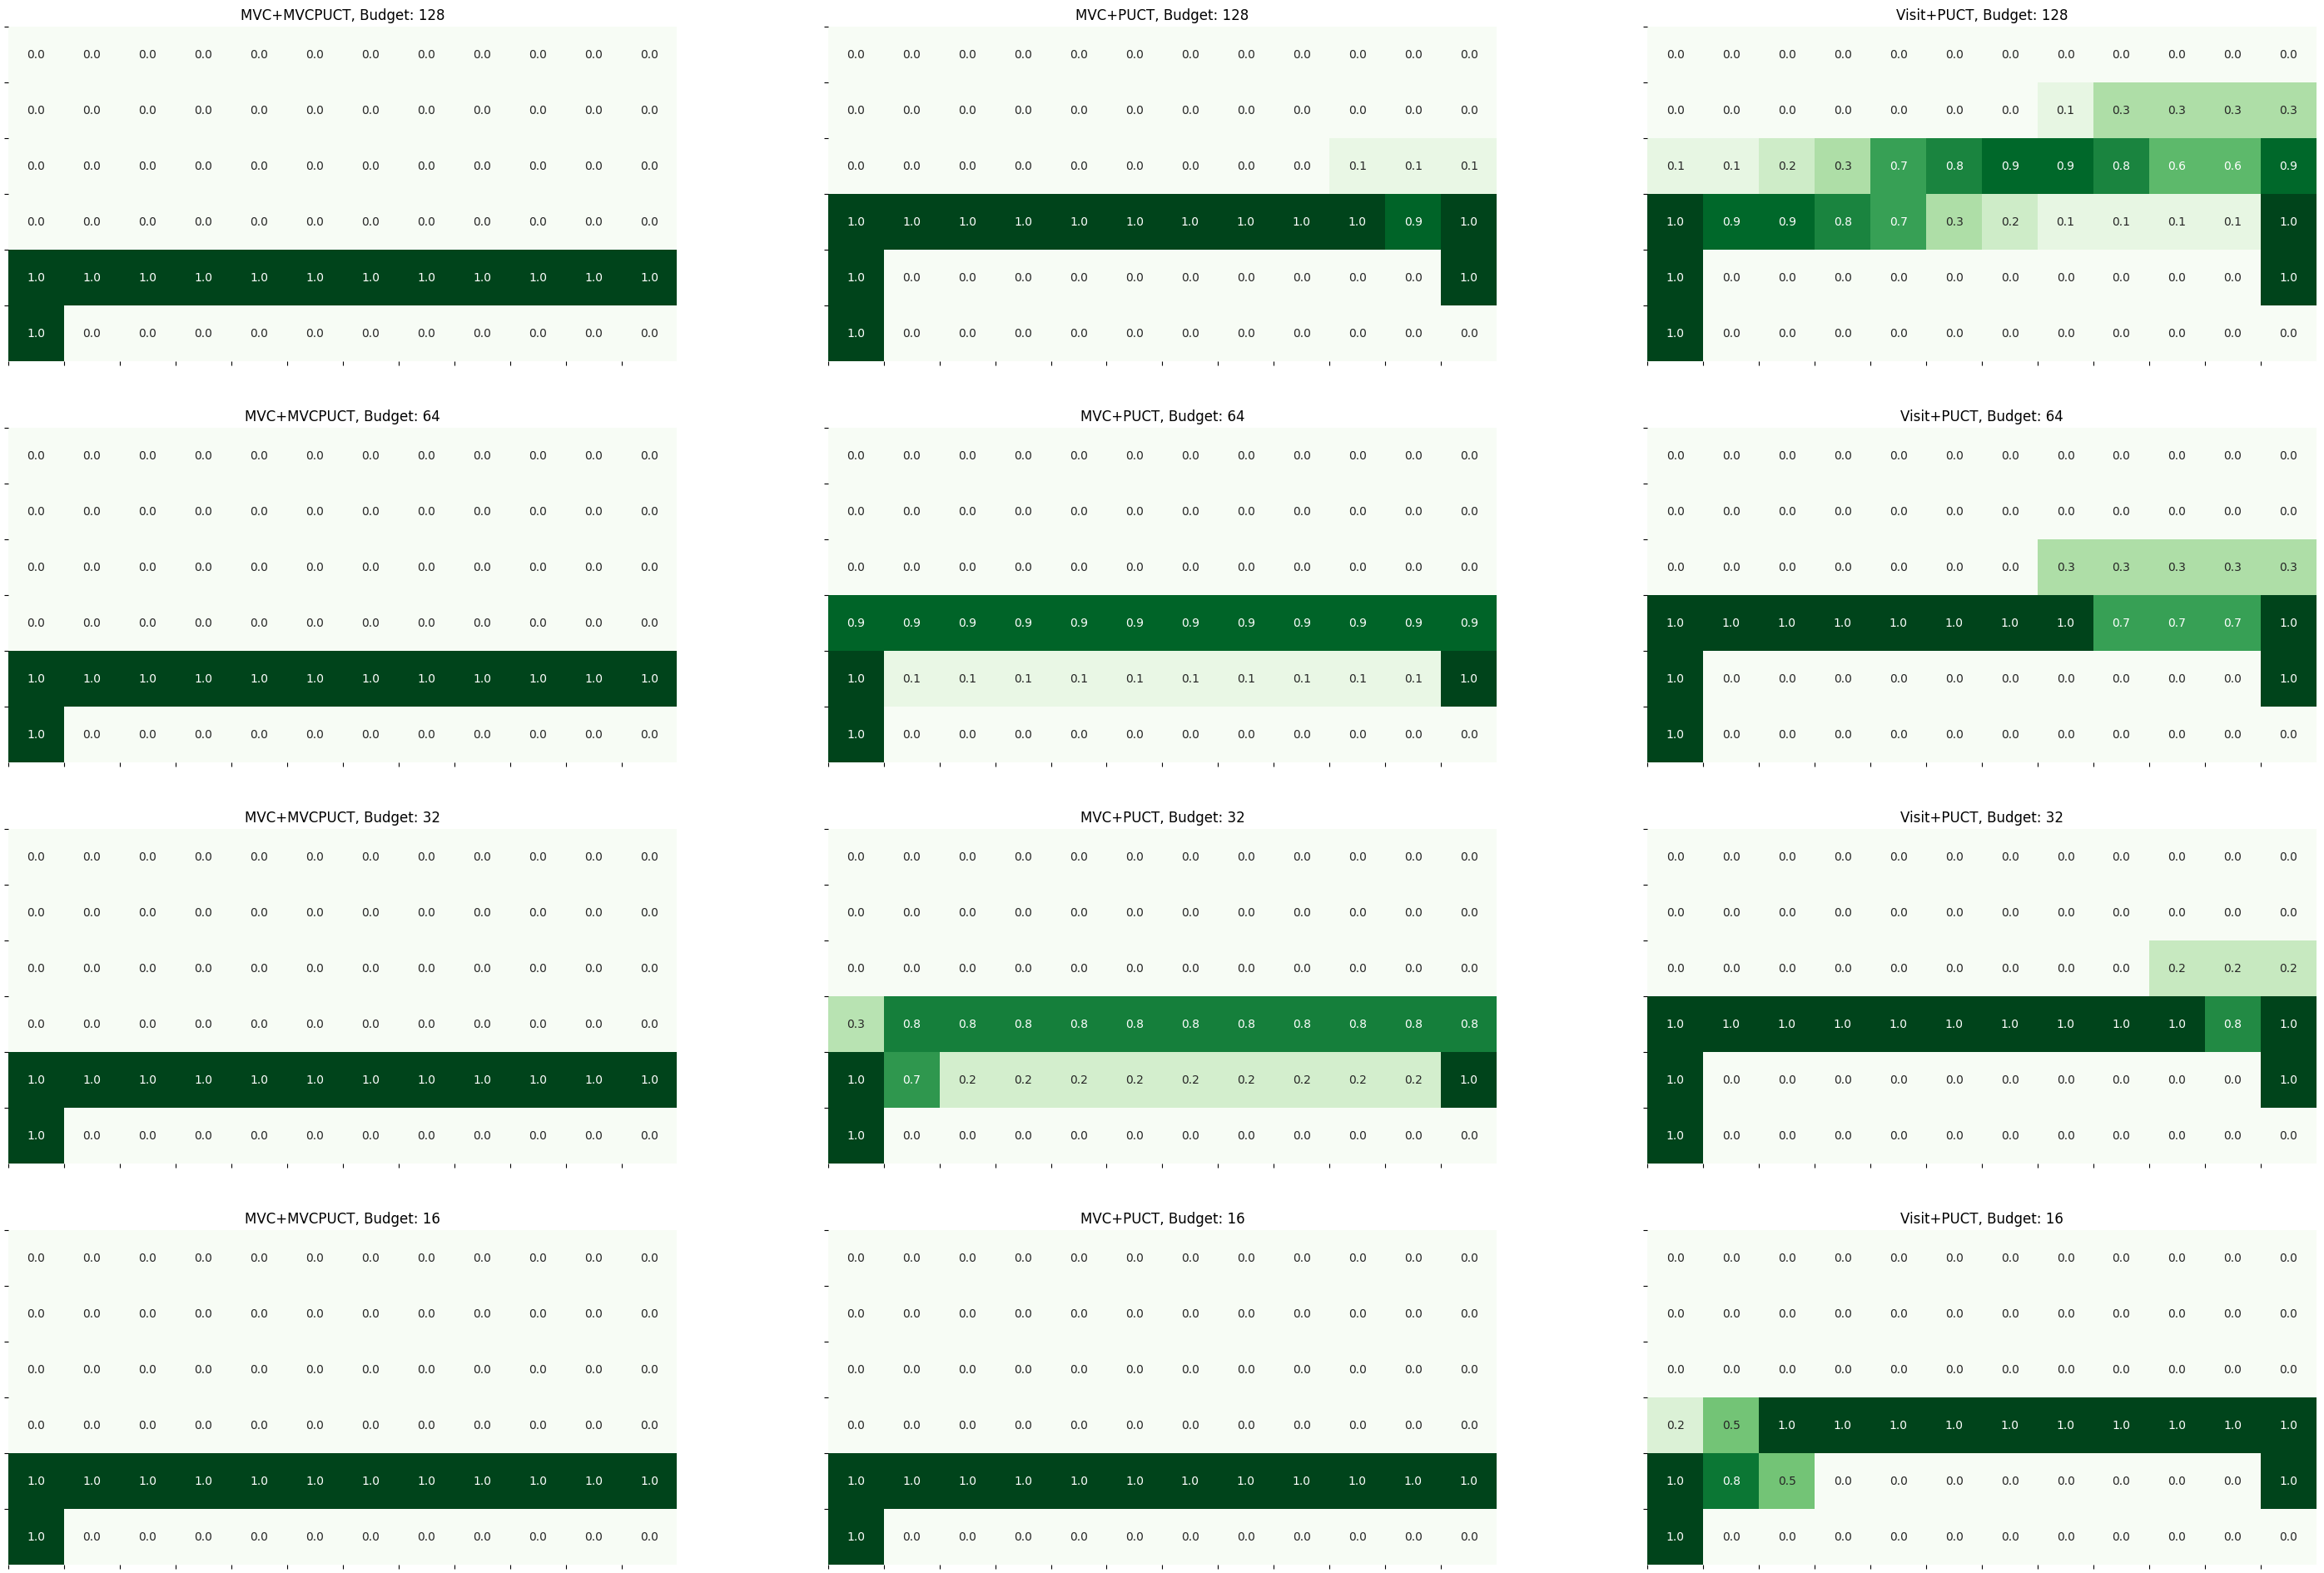

In [16]:
# filter out 128 planning budget
# Assuming 'df' is your DataFrame
df['policy_combination'] = df['tree_evaluation_policy'] + "+" + df['selection_policy']
policy_combination_mapping = {
    'mvc+PolicyPUCT': 'MVC+MVCPUCT',
    'mvc+PUCT': 'MVC+PUCT',
    'visit+PUCT': 'Visit+PUCT'
}

# Rename the policy combinations in the DataFrame
df['policy_combination'] = df['policy_combination'].map(policy_combination_mapping)
# Group the DataFrame by both 'policy_combination' and 'planning_budget'
grouped = df.groupby(['policy_combination', 'planning_budget'])['Evaluation/Trajectories']


# Aggregate the trajectories lists within each group
aggregated_trajectories = grouped.sum()

# Define functions to calculate coordinates and density
def obs_to_cords(state, ncols):
    row, col = divmod(state, ncols)
    return row, col

def calculate_density(trajectories, ncols, nrows):
    density = np.zeros((nrows, ncols))
    for trajectory in trajectories:
        for state in trajectory:
            row, col = obs_to_cords(state, ncols)
            density[row, col] += 1
    return density

# Determine the number of unique policy combinations and planning budgets
n_policies = len(df['policy_combination'].unique())
n_budgets = len(df['planning_budget'].unique())

# Prepare the plot
fig, axs = plt.subplots(n_budgets, n_policies, figsize=(ncols * n_policies, nrows * n_budgets))

# Plot each subgroup
for (policy_combination, planning_budget), trajectories in aggregated_trajectories.items():
    i = df['planning_budget'].unique().tolist().index(planning_budget)
    j = df['policy_combination'].unique().tolist().index(policy_combination)
    density = calculate_density(trajectories, ncols, nrows) / len(trajectories)
    ax = axs[i][j] if n_budgets > 1 and n_policies > 1 else axs[max(i, j)]
    sns.heatmap(density, ax=ax, cmap='Greens', cbar=False, annot=True, fmt='.1f')
    ax.set_xticks(range(ncols))
    ax.set_yticks(range(nrows))
    ax.set_aspect('equal')  # Set aspect ratio to be equal, making each cell square
    # set subtitle
    ax.set_title(f"{policy_combination}, Budget: {planning_budget}")




plt.savefig("outfiles/128_dist_training_cliff.pdf")
plt.show()


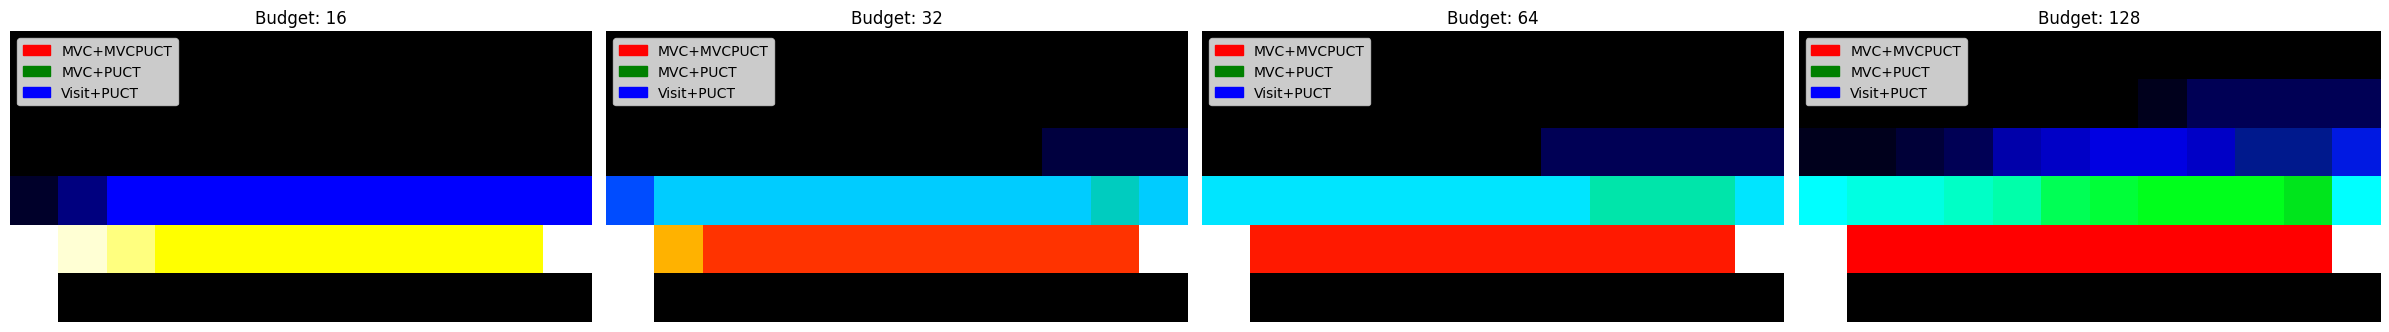

In [17]:
import matplotlib.patches as mpatches
grouped = df.groupby(['planning_budget', 'policy_combination'])['Evaluation/Trajectories'].sum()


# Determine the number of unique planning budgets
n_budgets = len(grouped.index.get_level_values(0).unique())

# Prepare a single figure with multiple subplots (one for each planning_budget)
fig, axs = plt.subplots(1, n_budgets, figsize=(6 * n_budgets, 6))

# Iterate over each planning_budget and create RGB heatmaps
for idx, (planning_budget, budget_group) in enumerate(grouped.groupby(level=0)):
    rgb_image = np.zeros((nrows, ncols, 3))  # Initialize RGB layers
    colors = ['Red', 'Green', 'Blue']  # Map trajos keys to RGB channels
    channel_colors = {name: color for name, color in zip(budget_group.index.get_level_values(1), colors)}

    # Compute density for each policy combination and assign to RGB channels
    for jdx, ((_, policy_combination), trajectories) in enumerate(budget_group.items()):
        density = calculate_density(trajectories, ncols, nrows) / len(trajectories)
        norm_density = density / np.max(density, where=(density!=0), initial=1)  # Normalize avoiding division by zero
        rgb_image[:, :, jdx % 3] += norm_density  # Accumulate in RGB layers, repeating colors if more than 3 policies

    ax = axs[idx] if n_budgets > 1 else axs
    ax.imshow(rgb_image, aspect='equal')
    ax.axis('off')  # Hide grid lines and labels

    # Create a legend
    legend_patches = [mpatches.Patch(color=color, label=name) for name, color in channel_colors.items()]
    ax.legend(handles=legend_patches, loc='upper left')
    ax.set_title(f"Budget: {planning_budget}")

plt.tight_layout()
plt.savefig("outfiles/dist_training_cliff_rgb.pdf")
plt.show()

In [18]:
df['policy_combination'].unique()

array(['MVC+MVCPUCT', 'MVC+PUCT', 'Visit+PUCT'], dtype=object)

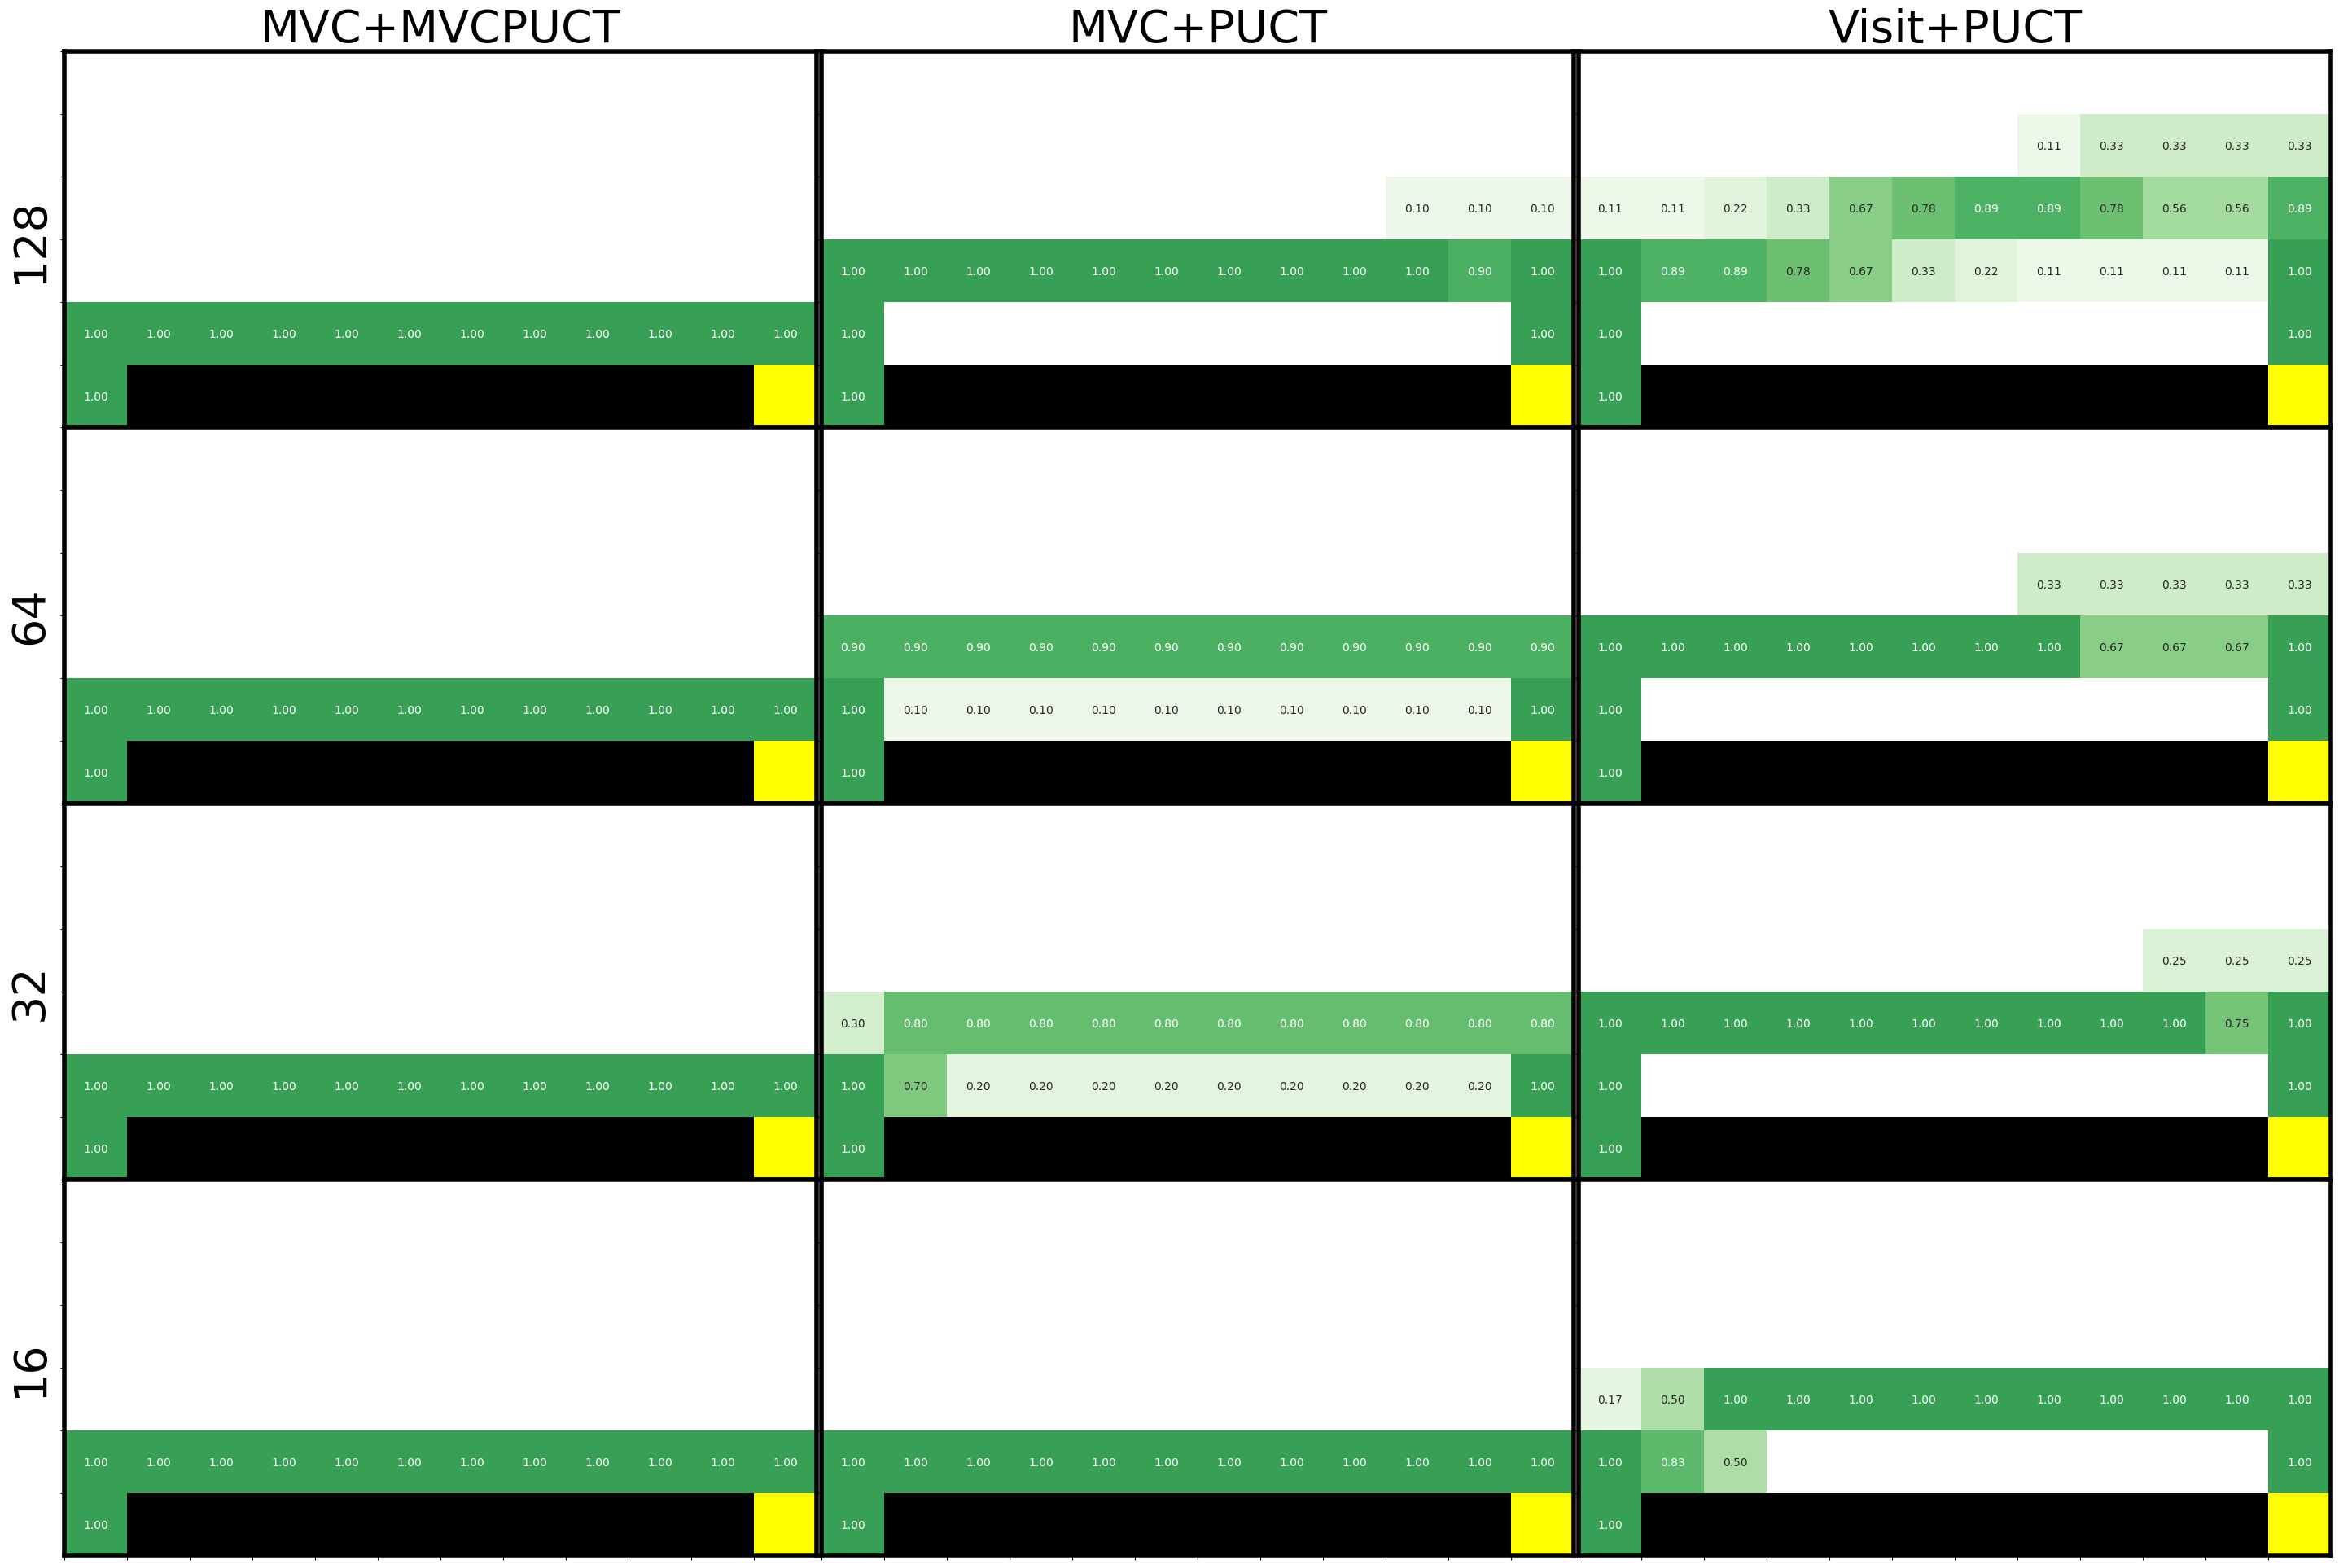

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as colors
filtered_aggregated_trajectories = aggregated_trajectories
# Determine the number of unique policy combinations and planning budgets
n_policies = len(df['policy_combination'].unique())
n_budgets = len(df['planning_budget'].unique())

# Prepare the plot
fig, axs = plt.subplots(n_budgets, n_policies, figsize=(ncols * n_policies, nrows * n_budgets))

# Cliff and goal state coordinates
cliff_coords = [(nrows - 1, col) for col in range(1, ncols - 1)]
goal_coord = (nrows - 1, ncols - 1)

# Plot each subgroup
for (policy_combination, planning_budget), trajectories in filtered_aggregated_trajectories.items():
    i = df['planning_budget'].unique().tolist().index(planning_budget)
    j = df['policy_combination'].unique().tolist().index(policy_combination)
    density = calculate_density(trajectories, ncols, nrows) / len(trajectories)

    # Set cliff and goal states to np.nan to hide their annotations
    for (row, col) in cliff_coords:
        density[row, col] = np.nan  # Remove numbers from the cliff cells
    goal_row, goal_col = goal_coord
    density[goal_row, goal_col] = np.nan  # Remove numbers from the goal cell

    ax = axs[i][j] if n_budgets > 1 and n_policies > 1 else axs

    # Create a custom colormap to highlight cliff and goal
    cmap = sns.color_palette("Greens", as_cmap=True)

    # Mask the 0.0 entries by setting them to NaN
    masked_density = density.copy()
    masked_density[masked_density == 0.0] = np.nan

    # Create a normalization instance with clip=True to ensure values above 1.5 are clipped
    norm = colors.Normalize(vmin=1e-3, vmax=1.5, clip=True)

    # Plot the heatmap
    sns.heatmap(masked_density, ax=ax, cmap=cmap, cbar=False, annot=True, fmt='.2f', mask=np.isnan(masked_density), norm=norm)
    # Use LogNorm for logarithmic color scaling
    # sns.heatmap(density, ax=ax, cmap=cmap, cbar=False, annot=True, fmt='.2f', mask=np.isnan(density), norm=colors.Normalize(1e-3, 1.5, clip=True))

    # Highlight the cliff states with black color
    for (row, col) in cliff_coords:
        ax.add_patch(plt.Rectangle((col, row), 1, 1, fill=True, color='black', lw=0))

    # Highlight the goal state with yellow color
    ax.add_patch(plt.Rectangle((goal_col, goal_row), 1, 1, fill=True, color='yellow', lw=0))

    ax.set_xticks(range(ncols))
    ax.set_yticks(range(nrows))
    ax.set_aspect('equal')  # Set aspect ratio to be equal, making each cell square

    # Set labels for the outer plots with larger font size
    if i == 0:
        ax.set_title(policy_combination, fontsize=40)
    if j == 0:
        ax.set_ylabel(f"{planning_budget}", fontsize=40)

# Adjust layout to remove space between subplots
plt.subplots_adjust(wspace=0, hspace=0)

# Add a border around each subplot
for ax in axs.flat:
    for _, spine in ax.spines.items():
        spine.set_visible(True)
        spine.set_linewidth(4)

plt.savefig("outfiles/cliff_training_density.pdf", bbox_inches='tight')
plt.show()
